In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### Download the Dataset

In [3]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = True  # use 'False' we can download the real CIFAR10 dataset

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### Reorganize the Dataset

In [4]:
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]    # read line by line without using pandas
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
labels

{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

### Split the Training, Validation, Testing Dataset

In [5]:
# copy file to the target directory
def copyfile(filename, target_dir):
    os.makedirs(target_dir, exist_ok=True)  # create as many subfolders as there are categories
    shutil.copy(filename, target_dir)      # move imgs to the corresponding subfolder

In [6]:
# first train on new training set, then tune on new valid set
# when get relatively good params, train on train+valid set, which is the original CIFAR10 training set
def reorg_train_valid(data_dir, labels, valid_ratio):
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))  
                                                # train+valid is the original CIFAR10 training set
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [7]:
# move test data to 'train_valid_test's subfolder 'test'
def reorg_test(date_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test',test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))  
                                    # put label of test data in 'unknown' folder

In [8]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [9]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

### Img Augmentation

In [10]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),   # enlarge imgs to 40*40
    torchvision.transforms.RandomResizedCrop(32, scale=(0.72, 1.0), ratio=(1., 1.)),  
                                            # 'scale' & 'ratio' are hyperparameters
    # 'scale' specifies the lower and upper bounds for the random area of the crop, before resizing
    # 'ratio' lower and upper bounds for the random aspect ratio of the crop, before resizing
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], # standardize each channel of the image
                                     [0.2023, 0.1994, 0.2010]) 
                                    # this comes from mean of whole ImageNet imgs in 3 channels
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])  # standardize each channel of the image
])

### Load the Dataset

In [11]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder), transform=transform_train)
        for folder in ['train', 'train_valid']]  # train_ds & train_valid_ds use training augmentation

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder), transform=transform_test) 
        for folder in ['valid', 'test']]         # valid_ds & test_ds use testing augmentation

In [12]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]   # 'drop_last=True' means 
                                                # drop the last batch if it is not up to batch_size we defined

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)
                    # But in testing data, we have to predict every imgs, so 'drop_last=False'

### Build the Net

In [13]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)   # d2l.resnet18(output_classes, input_channels)
    return net

loss = nn.CrossEntropyLoss(reduction='none')

In [14]:
# lr_period, lr_decay means after some epochs(lr_period), the lr rate will decay xx%(lr_decay)
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    # in PyTorch, .lr_scheduler.StepLR() can directly multiply lr_decay with lr after lr_period of epochs
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay) 
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    # from this part, it is only for showing the graph
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                                (metric[0] / metric[2], metric[1] / metric[2], None))
                
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()  # update after each scheduler(trainer), since trainer is in the scheduler
                          
    measures = (f'train loss {metric[0] / metric[2]:.3f},'
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                f' examples/sec on {str(devices)}')

train loss 1.960, train acc 0.260, valid acc 0.172
694.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


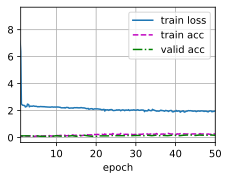

In [21]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 50, 1e-2, 5e-4
lr_period, lr_decay, net = 5, 0.5, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.329, train acc 0.899
692.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


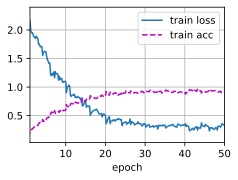

In [20]:
# after tuning, train on the original CIFAR10 training dataset
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
 
for X, _ in test_iter:   # y is fake label, so we ignore it
    y_hat = net(X.to(devices[0]))
    # get the largest labels in y_hat, then turn it into int32, then move to cpu, then change to numpy array
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
    
sorted_ids = list(range(1, len(test_ds)+1))
sorted_ids.sort(key=lambda x: str(x))   # run the expression after lambda

# put id%label in pd.DataFrame and save into a .csv file
df = pd.DataFrame({'id': sorted_ids, 'label':preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission_cifar10.csv', index=False) 